In [2]:
import pandas as pd
import numpy as np

# --- 1. Load your data ---

# If it's in a CSV file:
df = pd.read_csv("../data/processed/policy_term_counts.csv")

df.sort_values(by="count", ascending=False).head(10)

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/policy_term_counts.csv'

In [1]:
# Optional: if you want category + term as unique features, uncomment:
# df["feature"] = df["category"] + " :: " + df["term"]
# feature_col = "feature"
feature_col = "term"   # using just term as the feature name


# --- 2. Build document–term count matrix ---

# Pivot to get documents as rows, terms as columns, counts as values
dtm_counts = df.pivot_table(
    index="document",
    columns=feature_col,
    values="count",
    aggfunc="sum",
    fill_value=0
)

print("Document–Term Count Matrix:")
print(dtm_counts)


# --- 3. Compute TF-IDF manually ---

# Term Frequency (TF): count / total counts in that document
tf = dtm_counts.div(dtm_counts.sum(axis=1), axis=0)

# Document Frequency (DF): number of documents in which each term appears
dfreq = (dtm_counts > 0).sum(axis=0)

# Number of documents
N = dtm_counts.shape[0]

# Inverse Document Frequency (IDF)
# Using a smoothed version to avoid division by zero:
# idf = log((N + 1) / (df + 1)) + 1
idf = np.log((N + 1) / (dfreq + 1)) + 1

# Broadcast IDF across rows to get TF-IDF
tfidf = tf * idf

# For nicer display, make it a DataFrame with same index/columns as dtm_counts
tfidf_df = pd.DataFrame(tfidf, index=dtm_counts.index, columns=dtm_counts.columns)

print("\nTF–IDF Matrix:")
print(tfidf_df.round(4))

NameError: name 'df' is not defined

Nodes in document graph: ['artifact-1185435-file-1738559.pdf', 'artifact-1188191-file-1741315.pdf', 'artifact-1190753-file-1743877.pdf', 'artifact-1193237-file-1746362.pdf', 'artifact-1202799-file-1755913.pdf', 'artifact-1203109-file-1756218.pdf', 'artifact-1204147-file-1757256.pdf', 'artifact-1211321-file-1764432.pdf', 'artifact-1211936-file-1765036.pdf', 'artifact-1222493-file-1775570.pdf', 'artifact-1225396-file-1778468.pdf', 'artifact-1294280-file-1897485.pdf', 'artifact-1329267-file-1932558.pdf', 'artifact-1418182-file-2032451.pdf', 'artifact-1531938-file-2221696.pdf', 'artifact-1537792-file-2227603.pdf', 'artifact-1538060-file-2227871.pdf', 'artifact-1538337-file-2228148.pdf', 'artifact-1538362-file-2228173.pdf', 'artifact-1551483-file-2241292.pdf', 'artifact-1551484-file-2241293.pdf', 'artifact-1552409-file-2242218.pdf', 'artifact-1556883-file-2246692.pdf', 'artifact-1557849-file-2247658.pdf', 'artifact-1567677-file-2257458.pdf', 'artifact-1570727-file-2260459.pdf', 'artifact-15

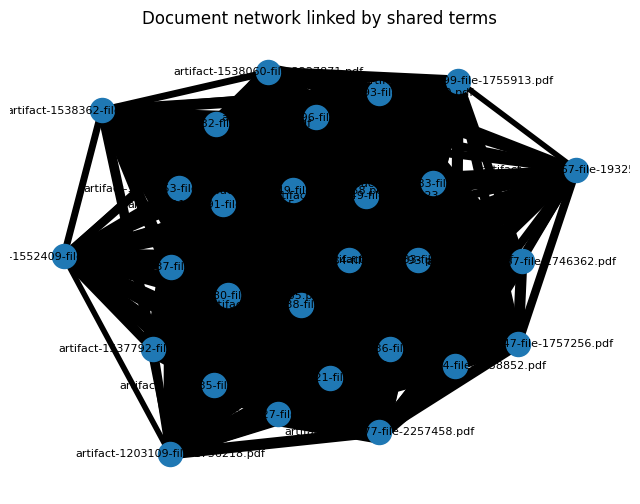

In [6]:
import networkx as nx

B = nx.Graph()

# Add document nodes (one partition)
documents = df["document"].unique()
B.add_nodes_from(documents, bipartite="document")

# Add term nodes (other partition)
terms = df["term"].unique()
B.add_nodes_from(terms, bipartite="term")

# Add edges between document and term with weight = count
for _, row in df.iterrows():
    doc = row["document"]
    term = row["term"]
    count = row["count"]
    # if multiple rows per doc-term pair exist, you can sum; here it's 1 row per pair
    if B.has_edge(doc, term):
        B[doc][term]["weight"] += count
    else:
        B.add_edge(doc, term, weight=count)


# --- 3. Project to document–document graph based on shared terms ---

# Get the set of document nodes
doc_nodes = [n for n, d in B.nodes(data=True) if d["bipartite"] == "document"]

# Weighted projection: edge weight = sum of shared term weights
# By default, weighted_projected_graph uses 'weight' from bipartite edges to compute weights
G_docs = nx.bipartite.weighted_projected_graph(B, doc_nodes)

print("Nodes in document graph:", G_docs.nodes())
print("Edges in document graph (with weights):")
for u, v, data in G_docs.edges(data=True):
    print(f"{u} -- {v}, weight={data['weight']}")


# --- 4. (Optional) Visualise the document graph with matplotlib ---

import matplotlib.pyplot as plt

pos = nx.spring_layout(G_docs, seed=42)
weights = [d["weight"] for _, _, d in G_docs.edges(data=True)]

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_docs, pos)
nx.draw_networkx_edges(G_docs, pos, width=weights)  # thicker edges = more shared term weight
nx.draw_networkx_labels(G_docs, pos, font_size=8)
plt.axis("off")
plt.title("Document network linked by shared terms")
plt.show()

In [8]:

# --- Export nodes.csv ---
nodes_df = pd.DataFrame({
    "id": list(G_docs.nodes()),
    "label": list(G_docs.nodes())
})
nodes_df.to_csv("../outputs/nodes.csv", index=False)

# --- Export edges.csv ---
edges_list = []
for u, v, data in G_docs.edges(data=True):
    edges_list.append({
        "source": u,
        "target": v,
        "weight": data.get("weight", 1)
    })

edges_df = pd.DataFrame(edges_list)
edges_df.to_csv("../outputs/edges.csv", index=False)

print("Export complete: nodes.csv and edges.csv created.")

Export complete: nodes.csv and edges.csv created.
